<a href="https://colab.research.google.com/github/BinXoai/Machine_Learning/blob/main/ABCBank_Customer_Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data munipulation
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})

# data processing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder,
                                   MinMaxScaler, StandardScaler,
                                   LabelEncoder)
from sklearn.compose import ColumnTransformer

# imblanced dataset
from imblearn.combine import SMOTEENN

# modelling
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier,ExtraTreesClassifier)
from sklearn.tree import (DecisionTreeClassifier, ExtraTreeClassifier)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, accuracy_score

#Debug lỗi không import được xgboost
import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier #!pip install xgboost



# 1. Preview Data

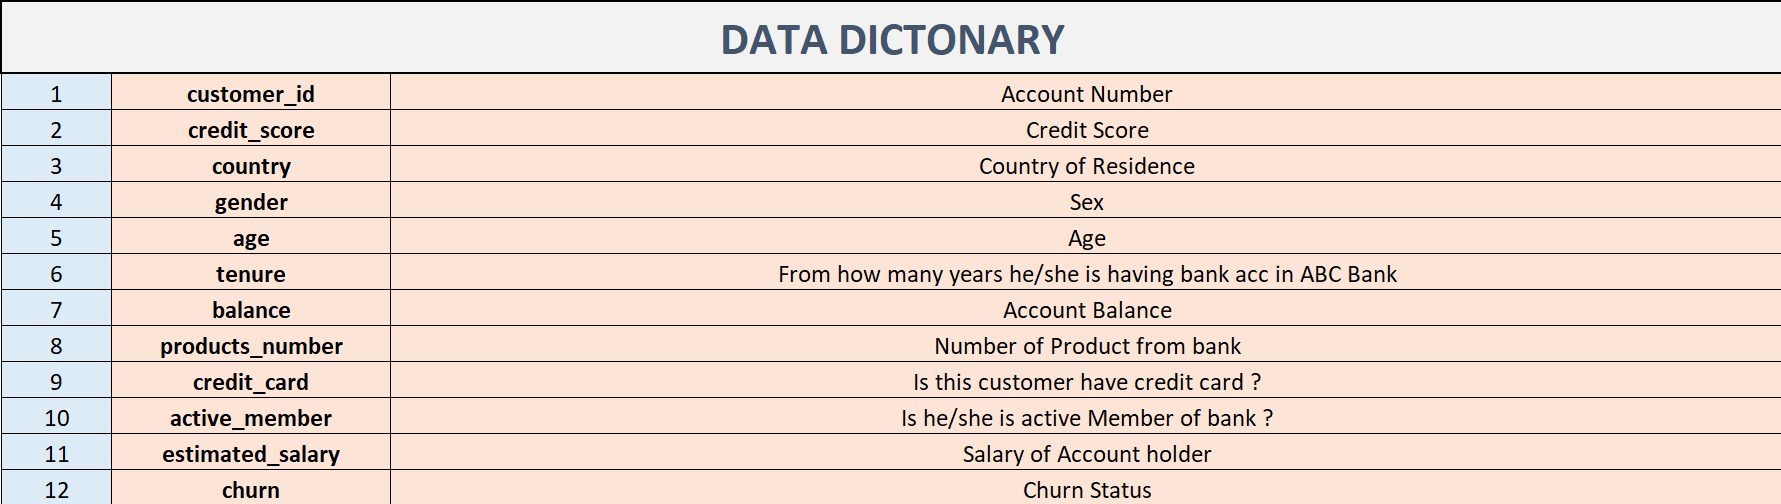

In [2]:
file_url = 'https://drive.google.com/file/d/18cXTFZ0ddX7apDb5sBsFzOv7hjluysiZ/view?usp=sharing'
file_id = file_url.split('/')[-2]
url = 'https://drive.google.com/uc?id=' + file_id

print(file_id)
print(url)

df = pd.read_csv(url)

18cXTFZ0ddX7apDb5sBsFzOv7hjluysiZ
https://drive.google.com/uc?id=18cXTFZ0ddX7apDb5sBsFzOv7hjluysiZ


In [3]:
df.head(3)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
df.tail(3)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9997,15584532,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,15628319,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [5]:
df.sample(3)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
9892,15796370,604,Spain,Male,40,5,155455.43,1,0,1,113581.85,0
4173,15747808,712,France,Male,29,3,102540.61,1,1,1,189680.79,0
9784,15687626,527,France,Male,39,4,0.00,2,1,0,167183.07,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [7]:
#Xem cấu trúc và unique của bộ data
n = df.shape[0]
for colname, dtype in df.dtypes.items():
    n_miss = df[colname].isna().sum()
    print("{cn:<30} | {dt:<7} | {nu:>5} | {cm:>7d} | {pm:>3.2f}%".format(
        cn=colname, dt=str(dtype), nu=df[colname].nunique(),
        cm=n_miss, pm=n_miss / n * 100
    ))

customer_id                    | int64   | 10000 |       0 | 0.00%
credit_score                   | int64   |   460 |       0 | 0.00%
country                        | object  |     3 |       0 | 0.00%
gender                         | object  |     2 |       0 | 0.00%
age                            | int64   |    70 |       0 | 0.00%
tenure                         | int64   |    11 |       0 | 0.00%
balance                        | float64 |  6382 |       0 | 0.00%
products_number                | int64   |     4 |       0 | 0.00%
credit_card                    | int64   |     2 |       0 | 0.00%
active_member                  | int64   |     2 |       0 | 0.00%
estimated_salary               | float64 |  9999 |       0 | 0.00%
churn                          | int64   |     2 |       0 | 0.00%


## Phân loại data:


*   Categorical: country,	gender, products_number,	credit_card,	active_member,churn
*   Numerical: credit_score, age, tenure, balance, estimated_salary



In [8]:
features = ['country', 'gender', 'products_number', 'credit_card', 'active_member','churn']
def convert_cat(df, features):
  for feature in features:
    df[feature] = df[feature].astype('category')
convert_cat(df, features)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customer_id       10000 non-null  int64   
 1   credit_score      10000 non-null  int64   
 2   country           10000 non-null  category
 3   gender            10000 non-null  category
 4   age               10000 non-null  int64   
 5   tenure            10000 non-null  int64   
 6   balance           10000 non-null  float64 
 7   products_number   10000 non-null  category
 8   credit_card       10000 non-null  category
 9   active_member     10000 non-null  category
 10  estimated_salary  10000 non-null  float64 
 11  churn             10000 non-null  category
dtypes: category(6), float64(2), int64(4)
memory usage: 528.3 KB


In [10]:
# data distribution
print('Numeric')
display(df.describe())

print('Categorical')
display(df.describe(exclude = [int, float]))

Numeric


,customer_id,credit_score,age,tenure,balance,estimated_salary
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,11.580000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,199992.480000


Categorical


,country,gender,products_number,credit_card,active_member,churn
count,10000,10000,10000,10000,10000,10000
unique,3,2,4,2,2,2
top,France,Male,1,1,1,0
freq,5014,5457,5084,7055,5151,7963


# 2. Exploratory Data Analysis (EDA)

In [11]:
drop_cols = ['customer_id']
target_col = 'churn'
feature_cols = [col for col in df.columns
                 if (col != target_col and
                      not col in drop_cols)]
df = df[sorted(feature_cols) + [target_col]]

## A. Target Vailable
`churn`

In [12]:
df['churn'].value_counts(normalize= True).to_frame()

,churn
0,0.7963
1,0.2037


Chỉ có 20% nhân viên nghỉ việc nên bị mất cân bằng trong bộ dữ liệu

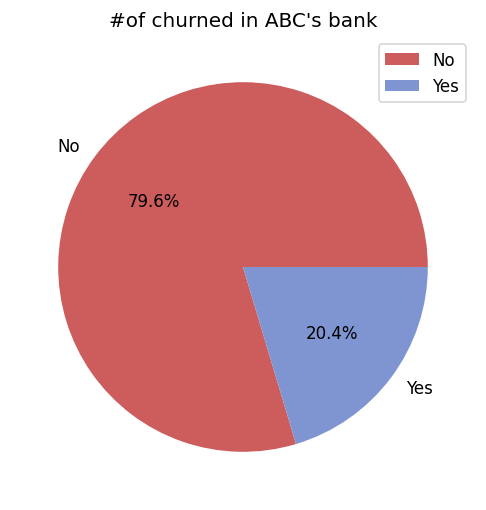

In [13]:
#Phần trăn churn
plt.figure(figsize=(5,5))
colors = ['#CD5C5C', '#7F95D1']
plt.pie(df['churn'].value_counts(), autopct='%1.1f%%', labels = ['No','Yes'],colors = colors)
plt.legend()
plt.title("#of churned in ABC's bank");

## B. Categorical Features

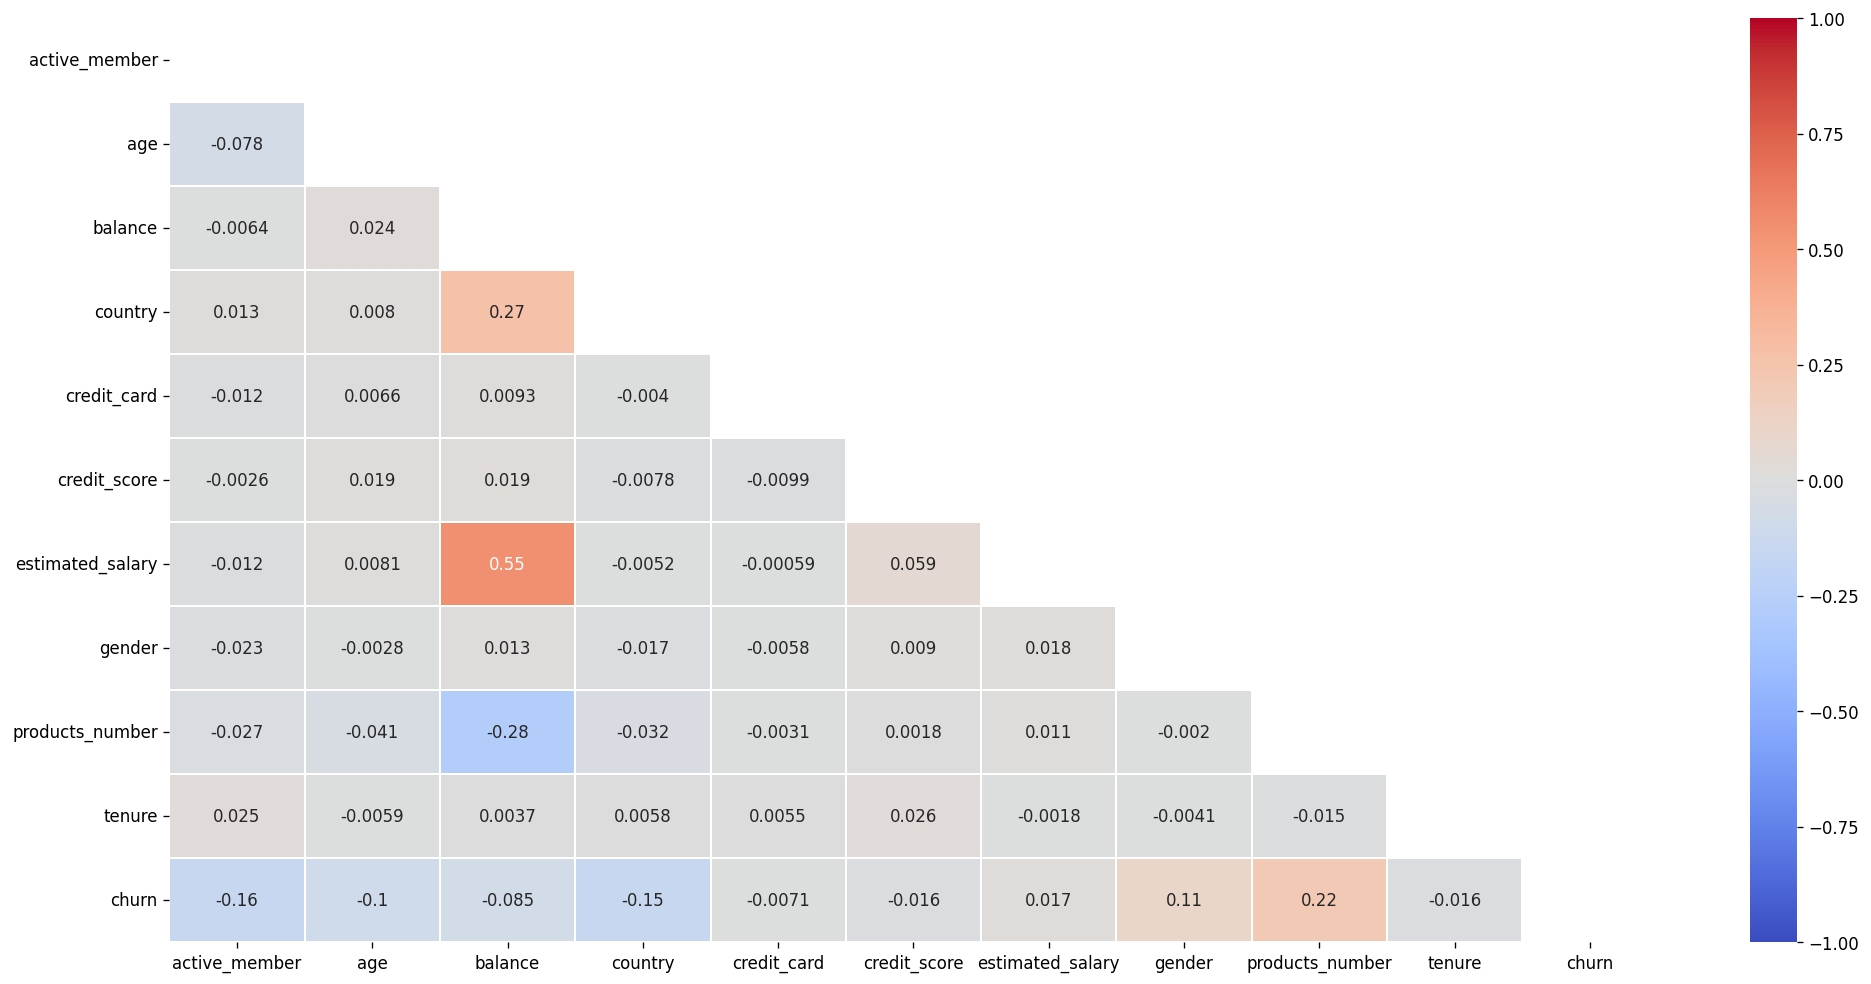

In [14]:
#Vẽ hình ma trận tương quan (correlation matrix) để xem tương quan giữa các biến
plt.figure(figsize=(20, 10))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

`products_number`

In [15]:
df['products_number'].value_counts().to_frame()

,products_number
1,5084
2,4590
3,266
4,60


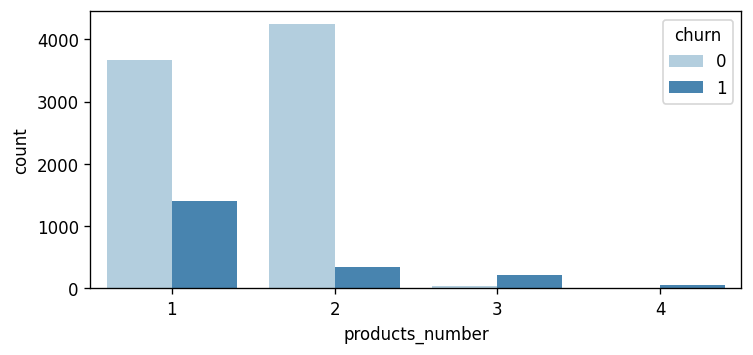

In [16]:
sns.countplot(data = df, x='products_number', hue='churn', palette = 'Blues');

Những người có số lượng product từ 3 - 4 có phần trăm nghỉ việc cao hơn

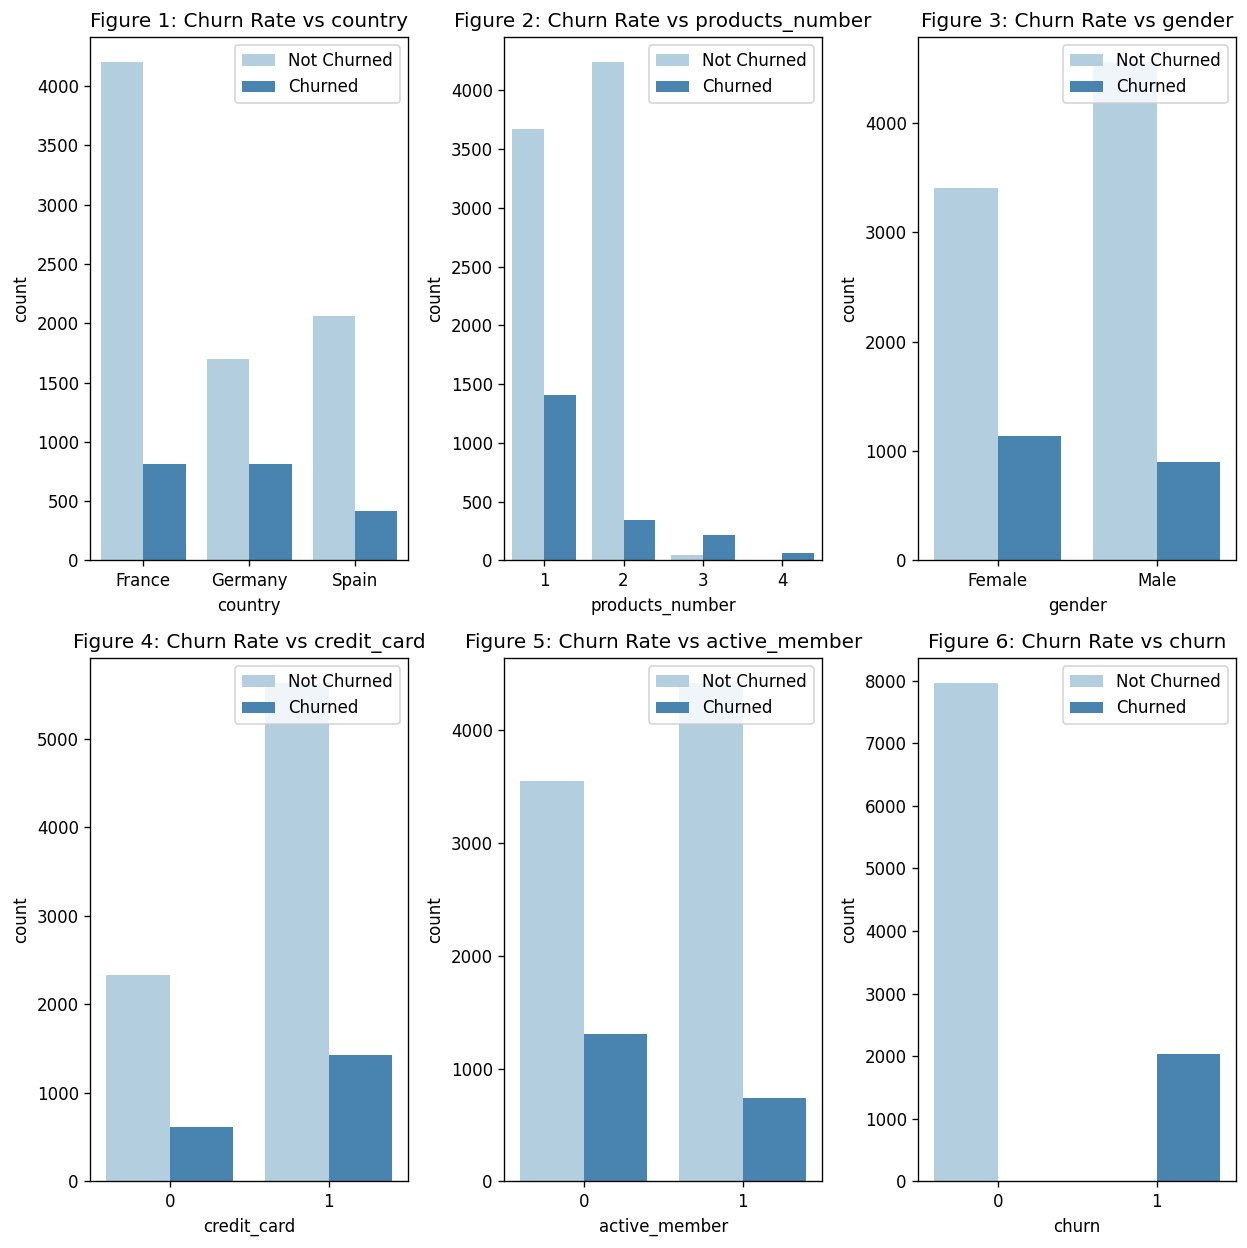

In [17]:
cols = ['country','products_number', 'gender', 'credit_card', 'active_member','churn']

n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_cols*3.5))

for r in range(0, n_rows):
  for c in range(0, n_cols):
    i = r*n_cols + c
    if i < len(cols):
      ax_i = ax[r,c]
      sns.countplot(data = df, x=cols[i], hue='churn',palette = 'Blues', ax=ax_i)
      ax_i.set_title(f"Figure { i+1}: Churn Rate vs {cols[i]}")
      ax_i.legend(title='', loc = 'upper right', labels =['Not Churned', 'Churned'])

# ax.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

## C. Numerical Feature

`Age`

In [18]:
df['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

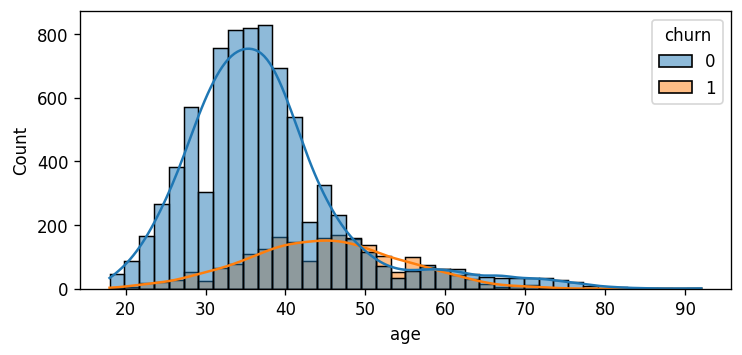

In [19]:
sns.histplot(data=df, x='age', hue='churn',bins = 40, kde = True);

Những người nghỉ việc có độ tuổi nằm trong khoảng từ 40 - 50 tuổi

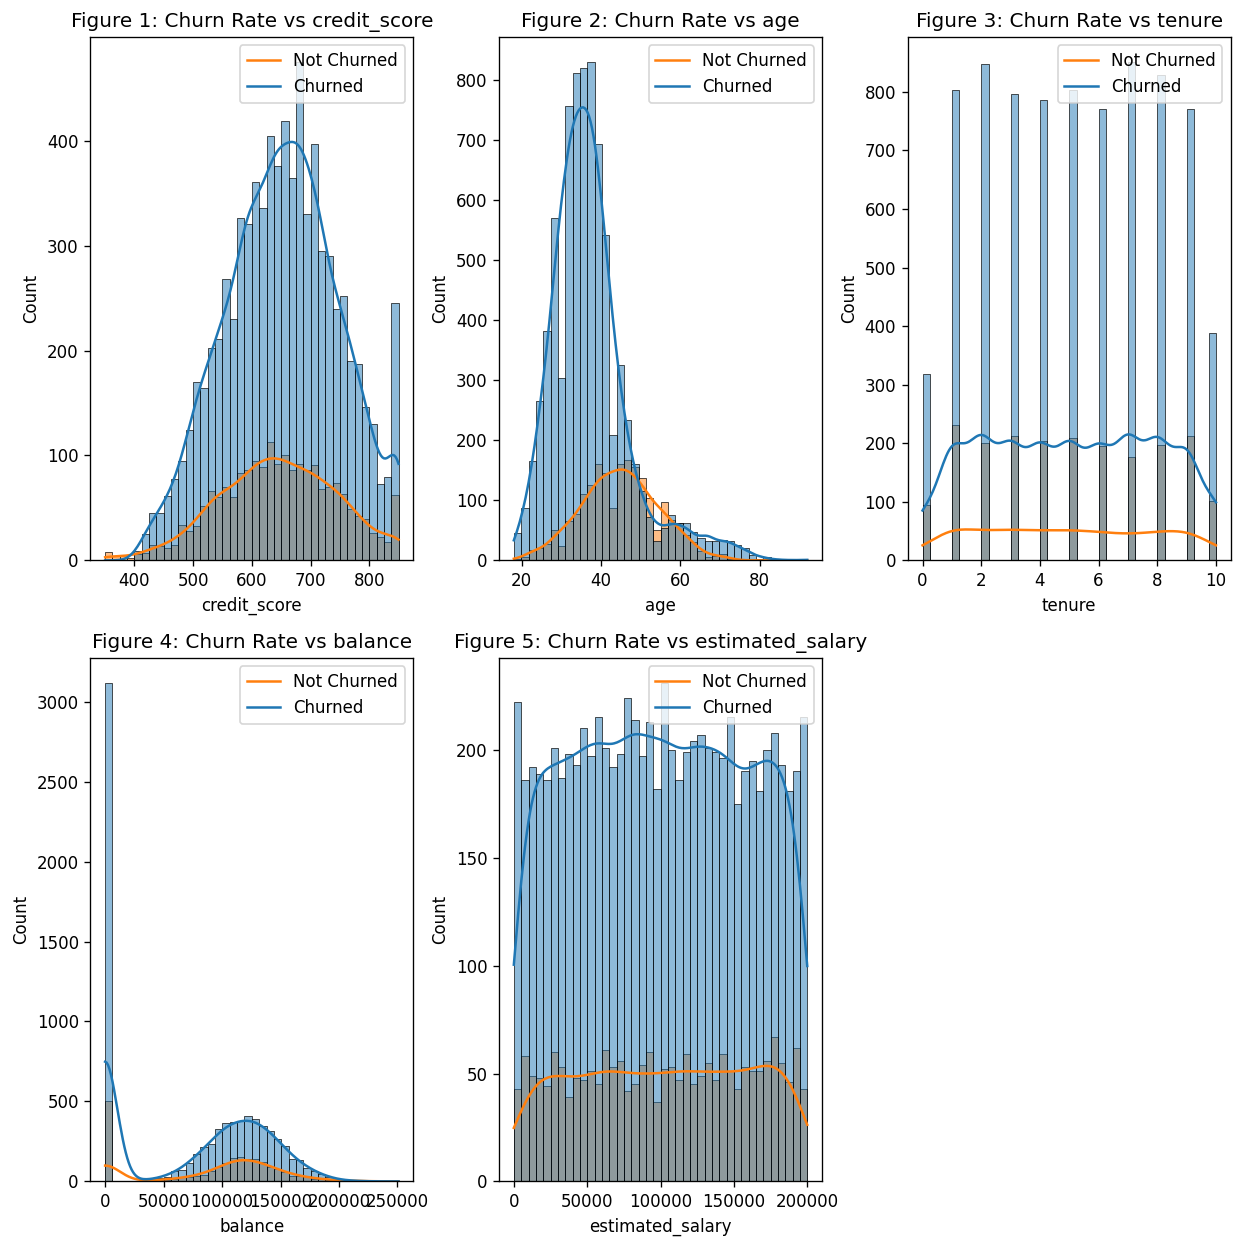

In [20]:
cols = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_cols*3.5))

for r in range(0, n_rows):
  for c in range(0, n_cols):
    i = r*n_cols + c
    if i < len(cols):
      ax_i = ax[r,c]
      sns.histplot(data = df, x=cols[i],hue='churn',bins = 40 ,kde=True, ax=ax_i)
      ax_i.set_title(f"Figure { i+1}: Churn Rate vs {cols[i]}")
      ax_i.legend(title='', loc = 'upper right', labels =['Not Churned', 'Churned'])

ax.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

# 3. Feature Engineering & Data Wrangling

## A. Feature Engineering
`tenure`

In [21]:
df['tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: tenure, dtype: int64

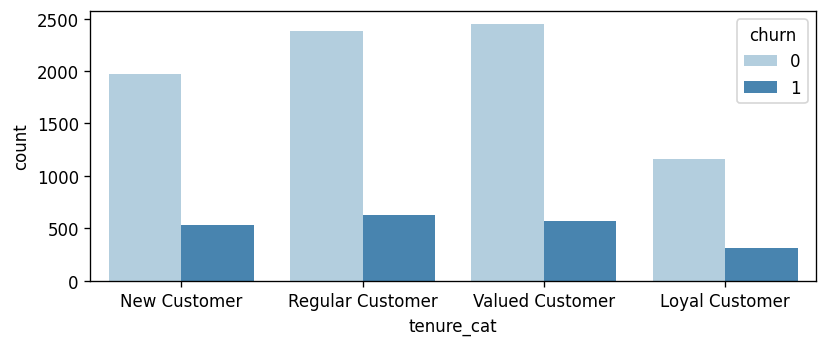

In [22]:
df['tenure_cat'] = pd.cut(df['tenure'], bins=[-1,2,5,8,20], labels=('New Customer','Regular Customer', 'Valued Customer', 'Loyal Customer'))

sns.countplot(data=df, x='tenure_cat',hue='churn',palette ="Blues")
plt.tight_layout()

## B. Data Wrangling

In [23]:
num_features = ['credit_score', 'age', 'balance', 'estimated_salary']
cat_features = ['country', 'gender','products_number','credit_card','tenure_cat', 'active_member']
feature_cols = num_features + cat_features
print(feature_cols)

['credit_score', 'age', 'balance', 'estimated_salary', 'country', 'gender', 'products_number', 'credit_card', 'tenure_cat', 'active_member']


In [24]:
def display_missing(df, feature_cols):
  n_rows = df.shape[0]
  for col in feature_cols:
    missing_count = df[col].isnull().sum()
    # if missing_count > 0:
    print(f"Col {col} has {missing_count*100/n_rows:.2f}% missing values.")
display_missing(df, feature_cols)

Col credit_score has 0.00% missing values.
Col age has 0.00% missing values.
Col balance has 0.00% missing values.
Col estimated_salary has 0.00% missing values.
Col country has 0.00% missing values.
Col gender has 0.00% missing values.
Col products_number has 0.00% missing values.
Col credit_card has 0.00% missing values.
Col tenure_cat has 0.00% missing values.
Col active_member has 0.00% missing values.


In [25]:
X = df[feature_cols]
y = df['churn']

In [26]:
#Preprocess pipeline
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer,num_features),
    ('cat',cat_transformer,cat_features)
])

In [27]:
X = preprocessor.fit_transform(X)

In [28]:
X = pd.DataFrame(data=X, index=df.index,
                        columns=preprocessor.get_feature_names_out())
X.head(3)

,num__credit_score,num__age,num__balance,num__estimated_salary,cat__country_France,cat__country_Germany,cat__country_Spain,cat__gender_Female,cat__gender_Male,cat__products_number_1,...,cat__products_number_3,cat__products_number_4,cat__credit_card_0,cat__credit_card_1,cat__tenure_cat_Loyal Customer,cat__tenure_cat_New Customer,cat__tenure_cat_Regular Customer,cat__tenure_cat_Valued Customer,cat__active_member_0,cat__active_member_1
0,-0.326221,0.293517,-1.225848,0.021886,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.440036,0.198164,0.117350,0.216534,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-1.536794,0.293517,1.333053,0.240687,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [52]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 4. Model Training

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=0)

In [54]:
X_train.shape, X_test.shape

((7000, 21), (3000, 21))

## Imbalance data

In [57]:
data_res = SMOTEENN()
X_res, y_res = data_res.fit_resample(X_train, y_train)

## Logistic Regression

In [58]:
log_reg = LogisticRegression(solver='liblinear', max_iter=1000,random_state=0)
log_reg.fit(X_res,y_res)

LogisticRegression(max_iter=1000, random_state=0, solver='liblinear')

In [59]:
y_pred_log_reg = log_reg.predict(X_test)

In [60]:
#Đánh giá mô hình
accuracy_score(y_test, y_pred_log_reg)

0.69

In [61]:
print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77      2379
           1       0.39      0.84      0.53       621

    accuracy                           0.69      3000
   macro avg       0.66      0.75      0.65      3000
weighted avg       0.83      0.69      0.72      3000



## Decision Tree

In [62]:
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, random_state = 0)
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, random_state=0)

In [63]:
y_pred_decision_tree = decision_tree.predict(X_test)

In [64]:
#Đánh giá mô hình
accuracy_score(y_test, y_pred_decision_tree)

0.8593333333333333

In [65]:
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2379
           1       0.74      0.49      0.59       621

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



In [66]:
# Sử dụng vòng lặp for để tìm max_depth
score_total=[]
for i in range(1,20):
  model_tree = DecisionTreeClassifier(max_depth=i)
  model_tree.fit(X_train, y_train)
  y_pred_decision_tree=model_tree.predict(X_test)
  score_total.append(accuracy_score(y_test,y_pred_decision_tree))

In [67]:
score_total

[0.793,
 0.82,
 0.8446666666666667,
 0.8566666666666667,
 0.853,
 0.8556666666666667,
 0.857,
 0.859,
 0.849,
 0.851,
 0.839,
 0.838,
 0.8316666666666667,
 0.8216666666666667,
 0.8213333333333334,
 0.8126666666666666,
 0.811,
 0.8063333333333333,
 0.803]

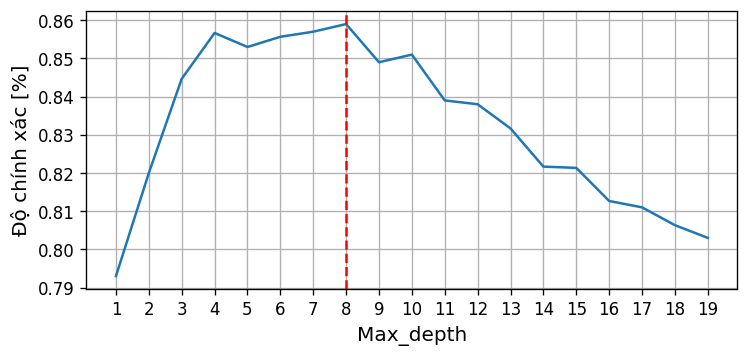

In [68]:
#Vẽ hình thể hiện độ chính xác theo giá trị max_depth
plt.rcParams.update({'figure.figsize':(7,3), 'figure.dpi':120})
plt.ylabel('Độ chính xác [%]',fontsize=12)
plt.xlabel('Max_depth',fontsize=12)
plt.plot(range(1, 20), score_total)
plt.xticks(range(1, 20))
plt.axvline(x=8, color='r', linestyle='--')
plt.grid('minor')

## Random Forest

In [69]:
random_forest = RandomForestClassifier(n_estimators=3, max_depth = None, random_state=0)
random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=3, random_state=0)

In [70]:
y_pred_random_forest = random_forest.predict(X_test)

In [71]:
#Đánh giá mô hình
accuracy_score(y_test, y_pred_random_forest)

0.828

In [72]:
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2379
           1       0.60      0.51      0.55       621

    accuracy                           0.83      3000
   macro avg       0.74      0.71      0.72      3000
weighted avg       0.82      0.83      0.82      3000



## Baseline Model Comparison

In [73]:
seed = 0
models = [
    LinearSVC(dual=True, max_iter = 12000, random_state=seed),
    SVC(random_state=seed),
    KNeighborsClassifier(metric='minkowski', p=2),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state=seed)
]

In [74]:
def generate_baseline_results(models, X, y, metrics, cv=5, plot_results=False):
    #Define k-fold                    #X, y là Cái ghi vào
    kfold = StratifiedKFold(cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X,y,scoring=metrics,cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_id', 'accuracy_score'])

    if plot_results:
        sns.boxplot(x = 'model_name', y = 'accuracy_score', data=cv_df, color='lightblue', showmeans = True)
        plt.title("Boxplot of Base-Line Model Accuracy using 5-fold cross-validation")
        plt.xticks(rotation=45)
        plt.show()

    # Summary result
    mean = cv_df.groupby('model_name')['accuracy_score'].mean()
    std = cv_df.groupby('model_name')['accuracy_score'].std()

    baseline_results = pd.concat([mean,std], axis = 1, ignore_index=True)
    baseline_results.columns = ['Mean', 'Standard Deviation']

    # Sort by accuracy
    baseline_results.sort_values(by=['Mean'], ascending = False, inplace=True)

    return baseline_results



    return cv_df
generate_baseline_results(models, X, y, metrics='accuracy', cv=5, plot_results=False)

,Mean,Standard Deviation
model_name,,
RandomForestClassifier,0.8582,0.004147
SVC,0.8575,0.005679
AdaBoostClassifier,0.8569,0.006259
XGBClassifier,0.8526,0.002945
ExtraTreesClassifier,0.8460,0.004213
LinearSVC,0.8382,0.006006
KNeighborsClassifier,0.8273,0.005322
DecisionTreeClassifier,0.7935,0.015046
